# MaSim Country Calibration

This note book is used for running the country calibration processes for eventual use in the experimental simulation process. This notebook and the accompanying toolkit was developed by James Brodovsky and Sarit Adhikari as part of the calibration efforts for Burkino Faso and Mozambique in 2025.

## Installation

The preferred use case is to install the toolbox package locally into a virtual environment. If you have cloned this repository, you can install the package using pip. 

```bash
pip install -e .
```

If you are using `uv` (and you should!) install via

```bash
uv pip install -e .
```

This will install the package in editable mode, allowing you to make changes to the code and have them reflected in your local environment. If for some reason you are not seeing the changes reflected, try re-installing the package locally using the above commands again.

Alternatively, and this should be done only if you are developing additional toolbox features, you can run this notebook from the root (top level) directory and direct import calls to the toolbox via 

```python 
from src.masim_analysis import *
```
where `*` is the specific module you are interested in.

## Package and repo structure

Please make note of the following directory structures: `conf` and `data`. These are the primary two directories for experimental country data and configuration files. The `conf` directory contains the configuration (.yml) files for the simulation, while the `data` directory contains the data files used in the simulation (typically raster files).

Each of these folders is organized by country. For example, if you are working with Mozambique, the directory structure would look like this:

```
data/
    moz/
        calibration/
        ...
conf/
    moz/
        calibration/
        ...
```
Additionally the templates folder contains the template files for the configuration files. These are used to generate the .yml files for the simulation.

## How to use this notebook

This notebook should be thought of as a structured interactive prompt. The notes sections guide you through the process of calibrating and validating a country. The code sections are generally organized into sections that can be run independently. The notebook breaks up individual workflows by using markdown headings and note blocks. Due to the some what long-running nature of the tasks that calibration and validation involve, you'll sometimes have to wait and shutdown the kernel the notebook is running on and pick up where you left off another time.

To that end, this notebook is designed to make things organized but also segmented. Keep calibration constants (name, population, etc.) in a block below this and make sure to run that block every time you start the notebook. Module and library imports should be handled in the workflow segment you are currently working on. It is recommend (for speed of execution) to separate out imports from code execution to save time on re-importing.

Workflows are generally separated by a horizontal rule:

---

## Calibration efforts

The primary calibration point is to relate the beta parameter (rate of infection/biting) with the population size of a given map pixel given that pixel's treatment access rate. This involves a few steps. As a preliminary step, obtain the relevant raster files that contain population data, district mapping values, treatment, and prevalence (pfpr2-10, or a similar name) and place it under `data/<country>`. fictitious calibration data will be stored under `data/<country>/calibration`. Create a new branch in the git repository for the calibration process. This is important to keep track of changes and to avoid conflicts with the main branch. The main branch should be reserved for strategy and treatment analysis. The workflow there should be to branch off from the main branch, implement the strategies and treatments, and then merge back in any useful changes. Strategy and treament analysis shouldn't be a main contribution to the main branch. The calibration branch name should be descriptive and include the country name, e.g., `calibration-moz`.

Calibration then occurs in two phases and should be done on a separate git branch. The first phase is generating the simulated data for beta calibration. This creates the fictitious configuration and data files. This concludes with several command and job files to be run on a cluster. At the moment this is configured to work on Temple University's OwlsNest cluster, but the resulting `*_cmds.txt` files simply contain a list of shell commands that execute the simulation and should be generalizable to whatever parallel computing cluster system you are using.

The second phase is started when the batch processing is completed and downloaded locally to the `output/<country>/calibration` directory. These files are then summarized and the prevalence and beta values are fit using a log-sigmoid curve fit when broken down by pixel population and treatment access rate. These fits are then used to generate the beta map for eventual use in the experimental simulation.

---

## Constants

These are the country specific parameters you are working within. Please run the below code block every time you start this notebook.

In [1]:
import numpy as np
import pandas as pd
from masim_analysis import utils
import os

# Input parameters (sonstants for each calibration permutation)
name = "moz"
birth_rate = 31.2 / 1000
death_rate = [0.049744, 0.064331, 0.064331, 0.064331, 0.064331, 0.00359, 0.00361, 0.00365, 0.00379, 0.00379, 0.133, 0.133, 0.0174, 0.0174]
age_distribution = [0.037, 0.132, 0.161, 0.142, 0.090, 0.086, 0.070, 0.052, 0.044, 0.044, 0.031, 0.041, 0.024, 0.017, 0.013, 0.017]
betas = [0.001, 0.005, 0.01, 0.0125, 0.015, 0.02, 0.03, 0.04, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.8, 1]
population_bins = [10, 20, 30, 40, 50, 75, 100, 250, 500, 1000, 2000, 5000, 10000, 15000, 20000]
# Get the unique treatment access rates
treatment, _ =  utils.read_raster(os.path.join("data", name, f"{name}_treatmentseeking.asc"))
access_rates = np.unique(treatment)
access_rates = access_rates[~np.isnan(access_rates)]
access_rates = np.sort(access_rates)
access_rates = access_rates.tolist()

### Calibration Input Parameters

These are the target year for the data available as well as the number of repetitions for each calibration combination.

In [2]:
# Calibration parameters (variables for each calibration permutation)
calibration_year = 2022  # This is the year from which we have pfpr data
reps = 20

### Raster data exploration

The first step is to read in the relevant rasters to get a sense of some of the big picture data. The rasters are stored in the `data/<country>` directory. This is then used to get some basic statistics to run calibration.

In [3]:
districts, _ =  utils.read_raster(os.path.join("data", name, f"{name}_districts.asc"))
population, _ = utils.read_raster(os.path.join("data", name, f"{name}_population.asc"))
prevalence, _ = utils.read_raster(os.path.join("data", name, f"{name}_pfpr210.asc"))
district_names = pd.read_csv(os.path.join("data", name, f"{name}_mapping.csv"), index_col="ID")
names = district_names.to_dict()["DISTRICT"]

#### Plot districts

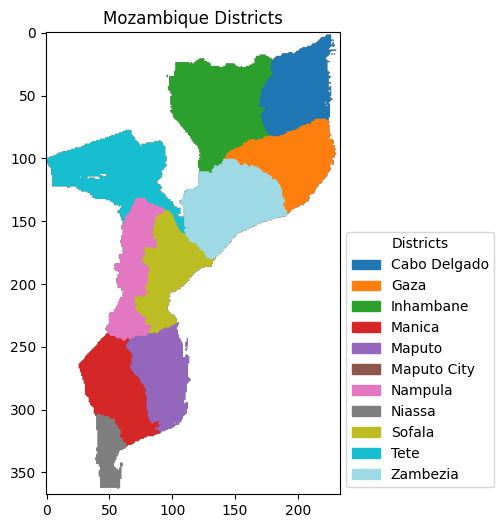

In [4]:
dist_fig = utils.plot_districts(districts, names, "Mozambique", fig_size=(12, 6), loc="lower right", bbox_to_anchor=(1.55, 0))

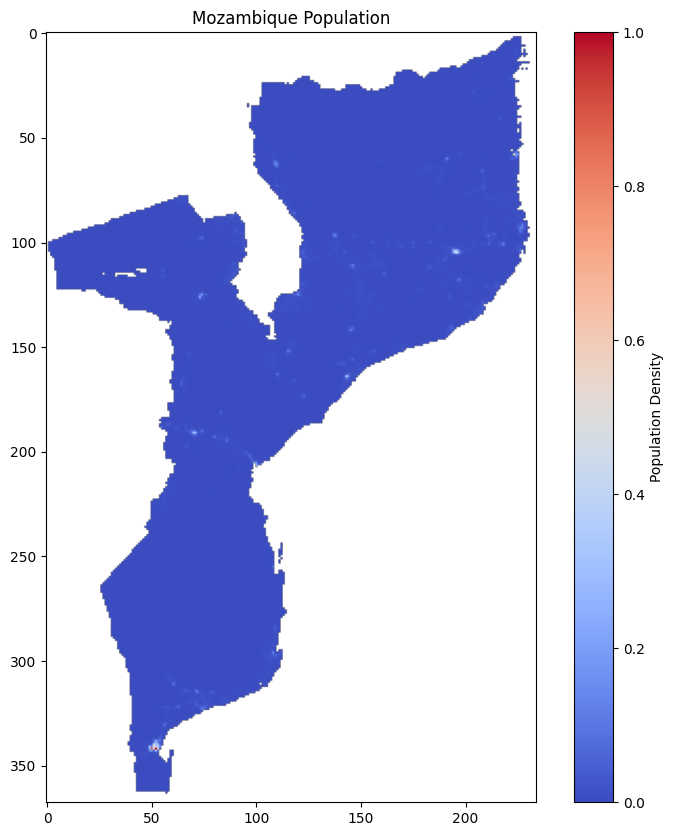

In [5]:
pop_fig = utils.plot_population(population, "Mozambique")

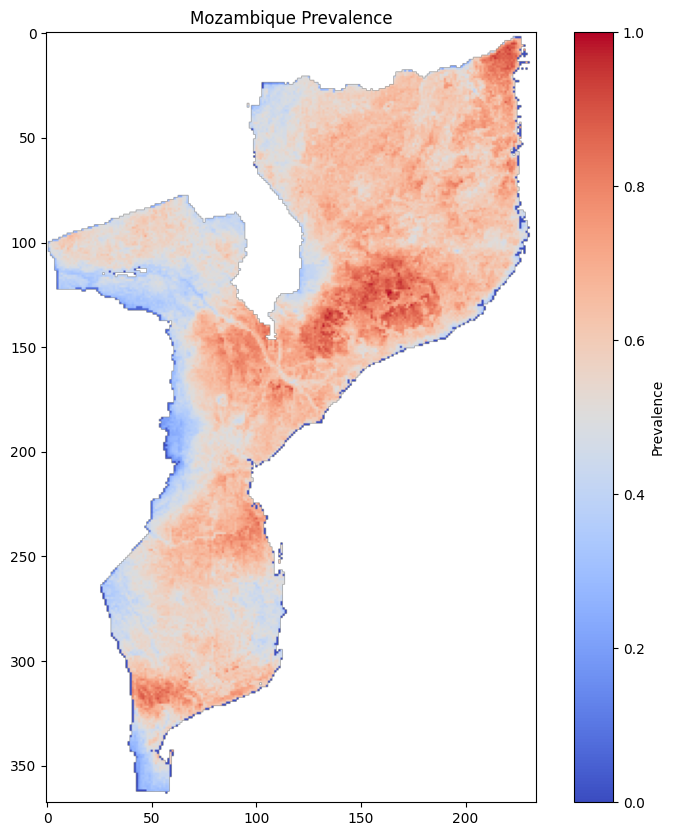

In [6]:
pfpr_plot = utils.plot_prevalence(prevalence, "Mozambique")

## Seasonality Calibration

Seasonality is a something of a manual process to fit precisely. The goal is to fit a curve that gives a scalar parameter that modifies the incidence rate for each day of the year. This is written to a `.csv` file historically called "adjustment" or "rainfall" and is a simple row-wise list of scalar values that effect the overall incidence or biting rate. This notebook choose to save this output as `seasonality.csv` in the `data/<country>/calibration` directory.

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt

cuamba = pd.read_csv(os.path.join("data", name, "calibration", "incidence cuamba.csv"))
inharrime = pd.read_csv(os.path.join("data", name, "calibration", "incidence inharrime.csv"))
c = cuamba[['month_num', 'cases/thousand']].copy()
i = inharrime[['month_num', 'cases/thousand']].copy()
s = pd.concat([c, i], axis=0)
s = s.dropna()

x = s['month_num'].to_numpy()
y = s['cases/thousand'].to_numpy()

fig, ax = plt.subplots(figsize=(12,2))
ax.plot(x, y, '.b', label='Data')
ax.set_xlabel('Month')
ax.set_ylabel('Cases/thousand')
ax.set_title('Seasonal signal')
plt.show()

As we know from previous work, the seasonality of malaria (and most diseases) is roughly sinusoidal. The goal is to fit a sinusoidal curve to the data. With that as well the working assumption of the Boni Lab is to use the positive half of the sine curve. There is not a strong stance on this as seasonal incidence modeling is not a major research concern of the lab. Simply put, taking the positive half of the sine curve is what previous publications from the lab has done and to avoid unneccesary problems in the peer review process, we will continue to do this. This notebook will walk through the process for the full sine curve for completeness' sake.

The fitting is done using the `scipy.optimize.curve_fit` function. The function takes in a model function and the data to fit. The model function is a sinusoidal function with a phase shift, period, amplitude, and offset.

$$
s(x) = A \sin\left(\frac{2 \pi x}{P} + \phi\right) + B
$$

In [ ]:
def seasonality(x, amplitude, period, phase, offset):
    """
    Generate a seasonal signal according to a sinusoidal model.
    """
    return amplitude * np.sin((2 * np.pi / period) * (x - phase)) + offset

def seasonality_positive_sine(x, amplitude, period, phase, offset):
    """
    Generate a seasonal signal according to a sinusoidal model.
    """
    s = seasonality(x, amplitude, period, phase, offset)
    s[s <= offset] = offset
    return s

We are looking to fit a scalar multiplier of the base incidence data not a curve over the specific incidence. We can do this by normalizing the incidence data about the median, mean, or mode.

In [ ]:
from scipy.stats import mode as spmode

median = np.median(y)
mean = np.mean(y)
mode = spmode(y)

In [ ]:
fig, ax = plt.subplots(figsize=(12,2))
ax.plot(x, y, '.b', label='Data')
ax.set_xlabel('Month')
ax.set_ylabel('Cases/thousand')
ax.set_title('Seasonal signal')
ax.axhline(median, color='r', linestyle='--', label='Median')
ax.axhline(mean, color='g', linestyle='--', label='Mean')
ax.axhline(mode.mode, color='y', linestyle='--', label='Mode')
ax.legend(loc='upper right', bbox_to_anchor=(1.12, 1))
plt.show()

Normailze the data with respect to the mean value.

In [ ]:
y_norm = y / mean

fig, ax = plt.subplots(figsize=(12,2))
ax.plot(x, y_norm, '.b', label='Normalized Data')
ax.set_xlabel('Month')
ax.set_ylabel('Cases / thousand')
ax.set_title('Seasonal signal')
ax.axhline(median / mean, color='r', linestyle='--', label='Normalized Median')
ax.axhline(mean / mean, color='g', linestyle='--', label='Normalized Mean')
ax.axhline(mode.mode / mean, color='y', linestyle='--', label='Normalized Mode')
ax.legend(loc='upper right', bbox_to_anchor=(1.22, 1))
plt.show()

Run the curve fit function and analyze with resepct to both the full sinusoid and the positive half of the sine curve.

In [ ]:
from scipy.optimize import curve_fit

fit = curve_fit(seasonality, x, y_norm, p0=[1, 365, 0, 1], maxfev=10000)

coefs = fit[0]

t = np.linspace(1, 12, 1000)

full_sine = seasonality(x, *coefs)
r2 = 1 - (np.sum((y_norm - full_sine)**2) / np.sum((y_norm - np.mean(y_norm))**2))
std_dev = np.std(y_norm - full_sine)

positive_sine = seasonality_positive_sine(x, *coefs)
r2_positive = 1 - (np.sum((y_norm - positive_sine)**2) / np.sum((y_norm - np.mean(y_norm))**2))
std_dev_positive = np.std(y_norm - positive_sine)

fig, ax = plt.subplots(figsize=(12, 2))
ax.plot(x, y_norm, '.b', label='Data (scaled)')
ax.plot(t, seasonality(t, *coefs), 'r-', label=f'Fitted curve\n$r^2$ = {r2:0.2f}\n$\sigma$: {std_dev:0.2f}')
ax.plot(t, seasonality_positive_sine(t, *coefs), 'g--', label=f'Fitted curve (positive sine)\n$r^2$ = {r2_positive:0.2f}\n$\sigma$: {std_dev_positive:0.2f}')
ax.set_xlabel('Month')
ax.set_ylabel('Incidence Scalar')
ax.legend(loc="upper right", bbox_to_anchor=(1.28, 1))
plt.show()

The fit is not great, but this is a relatively minor aspect of the simulation. The point is to introduce some degree of seasonal variation that is reasonable. Now let's transform the fit back to the incidence rate.

In [ ]:
fig, ax = plt.subplots(figsize=(12,3))
ax.plot(x, y, '.b', label='Data (scaled)')
ax.plot(t, seasonality_positive_sine(t, *coefs) * mean, 'g--', label='Fitted curve; R2 = %.2f' % r2)
ax.legend()
plt.show()

In [ ]:
# Write the fit to a file for 365 days
fit_x = np.arange(1, 366)
fit_y = seasonality_positive_sine(fit_x, *fit[0])
data = pd.DataFrame({"day": fit_x, "cases/thousand": fit_y})
data.index = data["day"]
data = data.drop(columns=["day"])
data.to_csv(os.path.join("data", name, f"{name}_seasonality.csv"), index=False, header=False)

## Run calibration data generation

The unknown that we are trying to solve for is the beta value(s). We have _real_ pixel-wise _prevalence_ (pfpr2-10) data that arrises from a given beta. The goal is to generate data that matches closely the real prevalence data by varying the beta value, population size, and access rate for a simulated single pixel. We will first generate the configuration files for the calibration runs here. 

In [7]:
# Country calibration script
import os
from datetime import date
from ruamel.yaml import YAML
from masim_analysis import calibrate

yaml = YAML()

Create the configuration files

In [ ]:
calibrate.generate_configuration_files(
    name,
    calibration_year,
    population_bins,
    access_rates,
    betas,
    birth_rate,
    death_rate,
    age_distribution,
)

Create the command and job files

In [ ]:
calibrate.generate_command_and_job_files(
    name,
    population_bins,
    access_rates,
    betas,
    reps,
    cores=28,
    nodes=8,
)

At this point you should have all the data and configuration files you need in order to run the calibration. The next step is to commit the changes (added files) to the local branch and push to the remote branch. Log into the cluster and switch to the branch you just created:

```bash
git checkout <branch_name>
git pull
```
Create the required output directories on the cluster: 

```bash
mkdir -p output/<country>/calibration
```

Ensure that the jobs files (typically `.sh`) are only the specific jobs that you want to run. Delete any other job or `.sh` files. Keep in mind that any given user may only have at most 50 jobs queued on Owl's Nest at a time. Queue up the calibration jobs using the following command:

```bash
for i in $(ls *.sh); do
    echo "Submitting job $i"
    qsub $i
done
```

This will submit all the jobs in the current directory. Give it a few minutes to queue up and then log into your cluster account and check the status of the jobs. At steady state, each job should be running approximately 28 processess simultaneously. The lower population size pixels do not take very long to run when spread out over several nodes (4-8, approximately 15-60 minutes). The larger population sizes (10k-20k) take much longer (10-12 hours).

### Process simulated data

Once the jobs are completed, you will need to download the output files from the cluster. This can be done using `scp` or `rsync`. For example, to download the output files from the cluster to your local machine, you can use the following command:

```bash
scp -r <username>@<cluster_address>:Temple-Malaria-Simulation-Analysis/output <local_path>
```
This will download the output files to the specified local path. I recommend simply copying them to your desktop. Once you have downloaded the output files, copy them to this repo (or download directly) and place them in the `output/<country>/calibration` directory. This will allow you to run the analysis on the simulated data locally.

Assuming that all or most of the calibration simulation executed successfull, delete all job and commands files.

---

## Check for missing data

Prior to running the full analysis, check for any missing data files. Sometimes Owl's Nest get hung, the database file didn't write correctly or some other bug happened.

In [8]:
import os
import pandas as pd
from datetime import date
from masim_analysis import calibrate

base_file_path = os.path.join("output", name, "calibration")
summary = pd.DataFrame(columns=["population", "access_rate", "beta", "iteration", "pfprunder5", "pfpr2to10", "pfprall"])

comparison = date(calibration_year, 1, 1)
year_start = comparison.strftime("%Y-%m-%d")
year_end = (comparison + pd.DateOffset(years=1)).strftime("%Y-%m-%d")

In [9]:
calibrate.process_missing_jobs(
    name,
    population_bins,
    access_rates,
    betas,
    os.path.join("output", name, "calibration"),
    reps,
)

100%|██████████| 15/15 [00:04<00:00,  3.30it/s]


If there are any missing data files run them on the cluster. This can be done by running the following command:

```bash
qsub missing_calibration_runs_<pop>_<access>.sh
```

---

### Summarize data

Once all the appropriate calibration data has been collected we need to summarize across all the individual data files. This will write the summarized results to `calibration_summary.csv` file in the `output/<country>/calibration` directory. The summary file will contain the following columns:
- `beta`: the beta value used in the simulation
- `population`: the population size of the pixel
- `access_rate`: the treatment access rate of the pixel
- `pfpr2_10`: the pfpr2-10 value of the pixel
- `pfprunder5`: the mean pfpr under 5 value of the pixel
- `pfprall`: the mean pfpr value of the pixel
- `iteration` : the iteration number of the simulation


In [ ]:
summary = calibrate.summarize_calibration_results(
    name,
    population_bins,
    access_rates,
    betas,
    calibration_year,
    os.path.join("output"),
    reps,
)

In [ ]:
# Save off the summary means
summary.to_csv(f"{base_file_path}/calibration_means.csv", index=False)

---

## Curve fitting

Now that we have summarized data that connects population size, treatment access, transmission rate, and prevelence, we can fit the data to a linear and log-sigmoid curve. Generally, the log-sigmoid appears to model the relationship better, but both methods are here for reference. This will allow us to generate a beta map for the experimental simulation. The beta map is generated by taking the beta value that corresponds to the population size and treatment access rate of each pixel. This is done using the `generate_beta_map` function, which takes the summarized data and generates a beta map for the experimental simulation.

In [ ]:
import json

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

from masim_analysis import calibrate

base_file_path = os.path.join("output", name, "calibration")
means = pd.read_csv(f"{base_file_path}/calibration_means.csv")
populations = means["population"].unique()
access_rates = means["access_rate"].unique()
betas = means["beta"].unique()
#group = means[(means["population"] == 100) & (means["access_rate"] == 0.65)]

### Linear fit

We're looking to fit the pfpr to beta relationship so that we can then use the real pfpr value from the raster data to determine the beta value. So, given a specific pixel's population, pfpr, and access rate (treatmentseeking?) calculate the beta value from this fitting method. We also don't have a decent way to serialize the linear models returned from sklearn, so at the moment this is just here for demonstration purposes.

Start using linear regression.

In [ ]:
# Determine grid size
num_rows = len(populations)
num_cols = len(access_rates)

# Create subplots grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 4 * num_rows), sharex=True, sharey=True)

# Ensure axes is always a 2D list for consistency
if num_rows == 1:
    axes = np.array([axes])  # Convert to 2D array
if num_cols == 1:
    axes = np.array([[ax] for ax in axes])  # Convert to 2D array

# Perform regression for each (Population, TreatmentAccess) group
for i, population in enumerate(populations):
    for j, treatment_access in enumerate(access_rates):
        ax = axes[i, j]  # Select subplot location

        # Filter the data for the current Population and TreatmentAccess
        group = means[(means["population"] == population) & (means["access_rate"] == treatment_access)]

        if group.empty:
            ax.set_visible(False)  # Hide empty plots
            continue

        group = group.dropna(axis=0)  # drop any row in a nan column

        X = group[["beta"]].values
        y = group["pfpr2to10"].values

        # 1. Linear Regression
        model = LinearRegression()
        model.fit(X, y)

        # 2. Polynomial Regression (degree 3)
        poly_model3 = make_pipeline(PolynomialFeatures(3), LinearRegression())
        poly_model3.fit(X, y)

        # 3. Polynomial Regression (degree 5)
        poly_model5 = make_pipeline(PolynomialFeatures(5), LinearRegression())
        poly_model5.fit(X, y)

        # 4. Spline Regression
        # spline_model = UnivariateSpline(group['beta'], group['pfpr2to10'], s=50)

        # Plot regression
        sns.scatterplot(x=group["beta"], y=group["pfpr2to10"], ax=ax, label="Data", color="black")
        ax.plot(group["beta"], model.predict(X), color="red", linestyle="dashed", label="Linear")
        ax.plot(group["beta"], poly_model3.predict(X), color="blue", linestyle="dashed", label="Poly (3)")
        ax.plot(group["beta"], poly_model5.predict(X), color="green", linestyle="dashed", label="Poly (5)")
        # ax.plot(group['Beta'], spline_model(X), color='purple', linestyle="dashed", label="Spline")

        # Setting titles & labels
        ax.set_title(f"Population : {population}, Access : {treatment_access}")
        if j == 0:
            ax.set_ylabel("pfpr2to10")
        if i == num_rows - 1:
            ax.set_xlabel("Beta")
        ax.legend(fontsize=7)

# Adjust layout
plt.suptitle("Curve Fitting by Population & Treatment Access", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Now we'll do a logarithemic fit for the beta value and attempt to fit a sigmoid curve. Again this is the model that typically works best for the data. The fit returned is a list of the parameters for the sigmoid function which can be easily serialized and saved to a file. The sigmoid function is defined as:
```python
def sigmoid(x, a, b, c):
    return a / (1 + np.exp(-b * (x - c)))
```
where `a`, `b`, and `c` are the parameters of the sigmoid function. The `x` value is the beta value. The `a` parameter is the maximum value of the sigmoid function, the `b` parameter is the steepness of the curve, and the `c` parameter is the x-value of the sigmoid's midpoint.

In [ ]:
models_map = {
        access_rate: {population: None for population in populations} for access_rate in access_rates
    }

In [ ]:
models_map = calibrate.log_sigmoid_fit(
    populations,
    access_rates,
    means,
)

In [ ]:
f = calibrate.plot_log_sigmoid_fit(models_map, populations[:5], access_rates[:5], means)

In [ ]:
with open(os.path.join("data", name, "calibration", "models_map.json"), 'w') as f:  # noqa: F811
    json.dump(models_map, f, indent=4)

Keep in mind that the built in JSON serialization and deserialization reads in all the values as strings. To get around this use `load_beta_model` from the `calibrate` module instead of the native `json.load()` function. This will convert the values back to numeric values and lists where appropriate.

In [ ]:
models_map = calibrate.load_beta_model(os.path.join("data", name, "calibration", "models_map.json"))

For an example of how to use the model mapping use the `get_beta` function

In [ ]:
from src.masim_analysis import calibrate, utils
import numpy as np

In [ ]:
districts, _ =  utils.read_raster("data/moz/moz_districts.asc")
population, _ = utils.read_raster("data/moz/moz_population.asc")
prevalence, _ = utils.read_raster("data/moz/moz_pfpr210.asc")
treatment, _ =  utils.read_raster("data/moz/moz_treatmentseeking.asc")

In [ ]:
beta_map = calibrate.create_beta_map(models_map, population, treatment, prevalence)

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
plt.imshow(beta_map, cmap="hot")